# TP3 - Paul Rongieras

## Rotation Prediction
In [1], authors propose to predict the geometric transformation applied to the entire image

<center width="100%"><img src="https://miro.medium.com/v2/resize:fit:908/1*enAk96Zn6andqoBetBy5Jg.png" width="800px" style="padding-top: 10px; padding-bottom: 10px"></center>

They propose to use rotations by 0, 90, 180, 270 degrees as trasformations.

[1] S. Gidaris et al. “Unsupervised Representation Learning by Predicting Image Rotations”. In: ICLR. 2018.

Let's load all libraries, we will use pytorch and pytorch vision, and check whether we are using CPU or GPU

In [2]:
import os

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

## Torchvision
from torchvision import transforms
from torchvision.datasets import STL10
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler

## Plot Options
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.set_cmap("cividis")
%matplotlib inline
sns.set_theme()

# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()
print("Number of workers:", NUM_WORKERS)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# For reproducibility
np.random.seed(666)
torch.manual_seed(666)

try:
  import google.colab
  IN_COLAB = True
  !pip install gdown==4.6.0 # with the following versions, there is an error
except:
  IN_COLAB = False

Hfactory=False # put equal to True, if you are using HFactory
if Hfactory:
    !pip install gdown==4.6.0 # with the following versions, there is an error

import gdown

Number of workers: 2
  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.1
    Uninstalling gdown-5.2.1:
      Successfully uninstalled gdown-5.2.1


<Figure size 640x480 with 0 Axes>

In [3]:
print("Using torch", torch.__version__)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print ("MPS device found.")
elif torch.backends.cuda.is_built():
    device = torch.device("cuda:0") # we use one GPU, the first one
    print ("CUDA device found.")
else:
   device = torch.device("cpu")
   print('No MPS or CUDA has been found. PyTorch will use CPU.')

Using torch 2.9.0+cu126
CUDA device found.


As Dataset, we will use the STL-10 dataset (https://cs.stanford.edu/~acoates/stl10/).
It is an image recognition dataset for developing self-supervised and unsupervised feature learning, deep learning algorithms. It is inspired by the CIFAR-10 dataset but with some modifications. In particular, each class has fewer labeled training examples than in CIFAR-10, but a very large set of unlabeled examples is provided.

Overview of the dataset:
- 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.
- Images are 96x96 pixels, color.
- 5000 training images (10 pre-defined folds), 8000 test images.
- 100000 unlabeled images. These examples are extracted from a similar but broader distribution of images. For instance, it contains other types of animals (bears, rabbits, etc.) and vehicles (trains, buses, etc.) in addition to the ones in the labeled set.
- Images were acquired from labeled examples on $ImageNet$.

Pytorch proposes two practical data primitives, called DataSet and DataLoader, to handle datasets for pre-processing and training.
There are many data-sets pre-loaded, such as STL-10. For more info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In particular, we can easily compose several data-augmentations (transformations), that are automatically applied to the images of the dataset. Here we have an exemple with the transformations used in [1].

We will use these transformations in the following.

**Question**: What's the size of the images after the transformations ? We have two different transformations, one for Training and one for Testing. Why in your opinion ?

*Answer*: After the transformations and due to the RandomResizedCrop(224) and CenterCrop(224), images will be of size 224x224.

Transformations are different between training and testing, as images are modified in the testing procedure (random resized, random rotation) to train the model with different type of images. However, in the testing procedure, we want fixed transformations on images to evaluate well the model's performances.

In [4]:
transformTrain = transforms.Compose([
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # these are the average and std from ImageNet
         ])

transformTest = transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
         ])

We will use only the training and test datasets (few images) to speed up computations.
- If you are using Google Colab, the STL10 dataset will be downloaded in `./data`. if you have already downloaded it in your Google Drive, you can mount it using the following line of code

from google.colab import drive

drive.mount('/content/drive')

and then either change the path.

- If you are running the code locally, just copy/paste the path of the folder where you have downloaded the dataset. In the code, I assume you have `stl10_binary.tar.gz` and the folder `stl10_binary` inside the `./data`folder.

In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
if IN_COLAB:
    #data_directory="./" # decomment it if you do NOT use Google Drive
    data_directory="/content/drive/MyDrive/data_colab/"  # decomment it if you USE Google Drive and copy/paste the path to your Google Drive
elif Hfactory:
    data_directory="./"
else:
    data_directory="/Users/pgori/Nextcloud/Lavoro/Corsi/MachineLearning/DataSets-TP/" # copy/paste the path of the folder with STL dataset in your computer


train_dataset = STL10(root=data_directory+"data", split="train", download=True, transform=transformTrain)
test_dataset = STL10(root=data_directory+"data", split="test", download=True, transform=transformTest)

Let's have a look at the training and test datasets.

In [8]:
# Train dataset
classes=train_dataset.classes
print(classes)
print('Number images in Train dataset:' , len(train_dataset)) # retrieve length of dataset
print(train_dataset[3][0].shape) # this is one image
print(train_dataset[3][1]) # this is a label

#Test dataset
print('Number images in Test dataset:' ,len(test_dataset))
print(test_dataset[0][0].shape) # this is one image

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
Number images in Train dataset: 5000
torch.Size([3, 224, 224])
6
Number images in Test dataset: 8000
torch.Size([3, 224, 224])


Let's plot few images to see how are they. We need to de-normalize images using the statics of ImageNet (images come from ImageNet)

In [9]:
def imshowSTL10(dataset,rows=3,columns=3,figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, rows*columns+1):
      img = dataset[i][0]

      #REMOVE NORMALIZATION
      mean = torch.tensor([0.485, 0.456, 0.406])
      std = torch.tensor([0.229, 0.224, 0.225])
      unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
      # Clip values to range [0,1] -> possible rounding errors during normalization
      img = np.clip(unnormalize(img).numpy(),0,1)

      label = dataset[i][1]
      fig.add_subplot(rows, columns, i)
      plt.title(dataset.classes[label])
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.axis("off")
    plt.show()

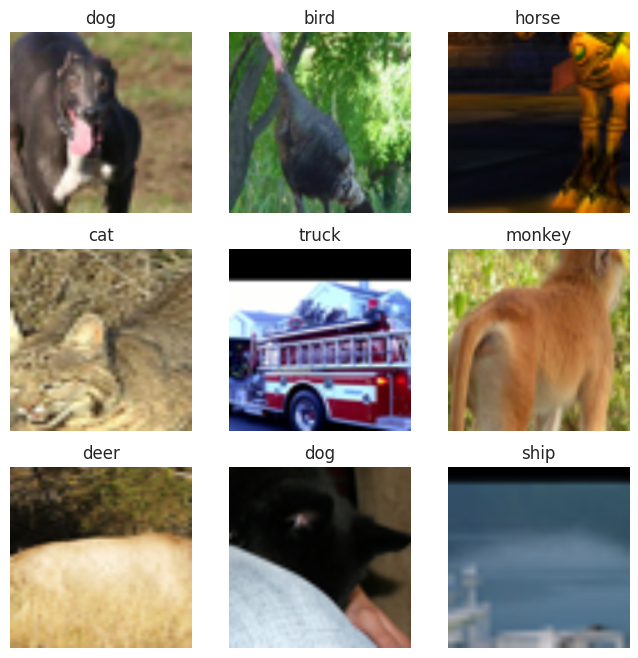

In [ ]:
imshowSTL10(train_dataset)

Now it's time to implement our network.

Since STL10 comes from ImageNet, we take the same network proposed for ImageNet in [1], inspired by AlexNet.

Here you can find the (modified) version of AlexNet (e.g., no DropOut) borrowed from the GitHub of the authors.  

**Question**: Choose an approriate value for num_classes and explain why

*Answer*: Given four possible geometric rotations (0, 90, 180, and 270 degrees) rotations, the model is trained to recognize the rotation that is applied to the image that it gets as input. So we choose num_classes = 4.

In [10]:
# Code borrowed from https://github.com/gidariss/FeatureLearningRotNet
# AlexNet
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        num_classes = 4

        conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
        )
        pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        conv3 = nn.Sequential(
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
        )
        conv4 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        conv5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        num_pool5_feats = 6 * 6 * 256
        fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_pool5_feats, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096, bias=False),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
        )
        classifier = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

        self._feature_blocks = nn.ModuleList([
            conv1,
            pool1,
            conv2,
            pool2,
            conv3,
            conv4,
            conv5,
            pool5,
            fc_block,
            classifier,
        ])
        self.all_feat_names = [
            'conv1',
            'pool1',
            'conv2',
            'pool2',
            'conv3',
            'conv4',
            'conv5',
            'pool5',
            'fc_block',
            'classifier',
        ]
        assert(len(self.all_feat_names) == len(self._feature_blocks))

    def _parse_out_keys_arg(self, out_feat_keys):

        # By default return the features of the last layer / module.
        out_feat_keys = [self.all_feat_names[-1],] if out_feat_keys is None else out_feat_keys

        if len(out_feat_keys) == 0:
            raise ValueError('Empty list of output feature keys.')
        for f, key in enumerate(out_feat_keys):
            if key not in self.all_feat_names:
                raise ValueError('Feature with name {0} does not exist. Existing features: {1}.'.format(key, self.all_feat_names))
            elif key in out_feat_keys[:f]:
                raise ValueError('Duplicate output feature key: {0}.'.format(key))

        # Find the highest output feature in `out_feat_keys
        max_out_feat = max([self.all_feat_names.index(key) for key in out_feat_keys])

        return out_feat_keys, max_out_feat

    def forward(self, x, out_feat_keys=None):
        """Forward an image `x` through the network and return the asked output features.
        Args:
          x: input image.
          out_feat_keys: a list/tuple with the feature names of the features
                that the function should return. By default the last feature of
                the network is returned.
        Return:
            out_feats: If multiple output features were asked then `out_feats`
                is a list with the asked output features placed in the same
                order as in `out_feat_keys`. If a single output feature was
                asked then `out_feats` is that output feature (and not a list).
        """
        out_feat_keys, max_out_feat = self._parse_out_keys_arg(out_feat_keys)
        out_feats = [None] * len(out_feat_keys)

        feat = x
        for f in range(max_out_feat+1):
            feat = self._feature_blocks[f](feat)
            key = self.all_feat_names[f]
            if key in out_feat_keys:
                out_feats[out_feat_keys.index(key)] = feat

        out_feats = out_feats[0] if len(out_feats)==1 else out_feats
        return out_feats

    def get_L1filters(self):
        convlayer = self._feature_blocks[0][0]
        batchnorm = self._feature_blocks[0][1]
        filters = convlayer.weight.data
        scalars = (batchnorm.weight.data / torch.sqrt(batchnorm.running_var + 1e-05))
        filters = (filters * scalars.view(-1, 1, 1, 1).expand_as(filters)).cpu().clone()

        return filters

And here it's the most important part of the code.

We build the RotationPrediction Module.

As in [1], we use the 'conv5' layer as representation features and a small classifier, as proposed in the paper.

The key part is in the 'forward' function and in '_preprocess'.

**Question**: complete the code XXXXXX in the '_preprocess' function. Remember that we are implementing the method of [1] as shown in the figure at the beginning of this TP.

In [11]:
## Joint optimization
class RotationPrediction(nn.Module):
    metrics = ['Loss', 'Acc1']
    metrics_fmt = [':.4e', ':6.2f']

    def __init__(self, n_classes_classifier, device):
        super().__init__()
        self.device=device
        self.model = AlexNet().to(self.device)
        self.latent_dim = 256 * 6 * 6 # as defined in [1]
        self.feat_layer = 'conv5' # as defined in [1]
        self.n_classes_classifier = n_classes_classifier

    # Same Classifier as defined in [1]
    def construct_classifier(self):
        classifier = nn.Sequential(
            nn.AdaptiveMaxPool2d((6, 6)),
            nn.BatchNorm2d(256, affine=False),
            nn.Flatten(),
            nn.Linear(self.latent_dim, self.n_classes_classifier)
        )
        classifier=classifier.to(self.device)
        return classifier

    def forward(self, images):
        images=images.to(self.device)
        batch_size = images.shape[0]

        #images must have a torch.Size([batch_size, Channels, Height, Width])
        #target must have a torch.Size([batch_size])
        images, targets = self._preprocess(images)
        targets = targets.to(self.device)

        logits, zs = self.model(images, out_feat_keys=('classifier', self.feat_layer))
        loss = F.cross_entropy(logits, targets).to(self.device)

        pred = logits.argmax(dim=-1)
        correct = pred.eq(targets).float().sum()
        acc = correct / targets.shape[0] * 100.

        zs = zs[:batch_size]
        return dict(Loss=loss, Acc1=acc), zs[:batch_size]

    def encode(self, images, flatten=True):
        zs = self.model(images, out_feat_keys=(self.feat_layer,))
        return zs.flatten(start_dim=1)

    def _preprocess(self, images):
        batch_size = images.shape[0]

        # Remember that the rotations should be computed using only two operations...

        # Original
        rotated_images = [images]
        targets = [torch.zeros(batch_size, dtype=torch.long)]

        # 90 degrees (transpose + vertical flip)
        rotated_images.append(images.transpose(2, 3).flip(2))
        targets.append(torch.ones(batch_size, dtype=torch.long))

        # 180 degrees (double flip)
        rotated_images.append(images.flip(2).flip(3))
        targets.append(torch.full((batch_size,), 2, dtype=torch.long))

        # 270 degrees (transpose + horizontal flip)
        rotated_images.append(images.transpose(2, 3).flip(3))
        targets.append(torch.full((batch_size,), 3, dtype=torch.long))

        # These are the Images to Predict and must have a torch.Size([batch_size, Channels, Height, Width])
        images_batch = torch.cat(rotated_images, dim=0)

        # Target are Labels (0,1,2,3) and must have a torch.Size([batch_size*4])
        targets = torch.cat(targets, dim=0)

        return images_batch, targets

Here we train our algorithm and evaluate its prediction power on a test set (function 'validate') using the function `accuracy`.

**Question**: Do you understand what the function accuracy compute ? Explain what the output `res` contains

*Answer*: this function computes the top-1 and top-k accuracies, such that it looks at the k best scores, and assess True if the real class is present. `res` is a tensor list containing for example the top-1 and top-3 accuracies if we have specified `topk=(1,3)`.

In [12]:
def accuracy(output, target, topk=(1,)):

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True) # sliced torch.argsort (for each row, it outputs the indices containing the k max values)
        pred = pred.t() # transpose to get batches as last dimension
        correct = pred.eq(target.view(1, -1).expand_as(pred)) # first transpose then expand target to be the same size as pred and then elementwise-equality

        # compute number of samples in the batch that has correct label in the k highest predictions
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

Now we can define our train function.


**Question**: Look at the optimization process and describe it. How do we minimize the rotation prediction module and classifier ? Could you do it differently ?

*Answer*: We decompose the optimization process into 2 differents steps. First, the SSL step where the model learns the characteristics of the images, solving the rotation problem, and we compute the gradient of the SSL loss (cross-entropy in the model). Second, the classification step using `zs` the vector of characteristics, and a standard cross-entropy loss. We detach `zs`for this step to consider the model as a fixed feature extractor.

It is possible to do differently by using only one optimizer, leading to possibly better performances but destroying the feature representation. We could also do sequential learning, divising clearly the 2 optimizing steps, allowing the classifier to train on fixed representations.

In [13]:
def train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device):

    model.train()
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)
        out, zs = model(images)
        zs = zs.detach() # detach from the graph,  requires_grad = False

        # compute optimizer step for ssl task using the previously defined Loss function of the model
        optimizer.zero_grad()
        out['Loss'].backward()
        optimizer.step()

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        #if i % 20 == 0:
        #    print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

Here, we define the:
- DataLoader, a pytorch object that wraps an iterable around the Dataset to enable easy access to the samples duing training or validation
- optimization process
- the sceduler
- all hyper-parameters (max epochs, batch size, lr, weight decay,etc.)

Please note that it will launch the training process. It can last some time... OR

you can directly load a pre-trained model in the following cell !

**Question**: what's the correct value for n_classes_classifier using the STL dataset ?

*Answer*: There is initially 10 classes in the STL dataset so the answer is 10.

In [14]:
maxepochs=5 # maximum number of epochs
bs=256 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

for epoch in range(maxepochs):
  top1Tr, top5Tr = train(train_loader, model, classifier, optimizer, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)
  scheduler.step()
  scheduler_classifier.step()


Device: cuda:0
Epoch: 0, Average loss: 0.0026, Average acc 1: 14.2854, Average acc 5: 59.3038
Epoch: 1, Average loss: 0.0019, Average acc 1: 17.6459, Average acc 5: 64.2716
Epoch: 2, Average loss: 0.0013, Average acc 1: 19.5611, Average acc 5: 67.9768
Epoch: 3, Average loss: 0.0008, Average acc 1: 22.4839, Average acc 5: 73.2640
Epoch: 4, Average loss: 0.0006, Average acc 1: 25.6457, Average acc 5: 76.8486


If you want to save your model, we can use torch.save

In [15]:
os.makedirs(data_directory+'models/', exist_ok=True)
filename = 'models/checkpoint_rotation_2epochs.pth.tar'
torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'state_dict_classifier': classifier.state_dict(),
                'optimizer_classifier': optimizer_classifier.state_dict(),
                'schedular_classifier': scheduler_classifier.state_dict()
            }, data_directory+filename)

If you want, here you can download the same model as before but already pre-trained for 50 epochs.

It's important to set the 'model.eval()' since we want to evaluate it and not train it (no gradient is computed and parameters are not updated)


In [ ]:
model_path = 'models/checkpoint_rotation_50epochs.pth.tar'

if os.path.isfile(data_directory+model_path):
    print("pre-trained model already downloaded")
else:
    print("downloading the pre-trained model")
    os.makedirs(data_directory+'models/', exist_ok=True)
    file_url = 'https://drive.google.com/uc?id=1ADslBKLjo1ulEfmz12ufEk2cjqnYJVRp'
    gdown.download(file_url, data_directory+model_path)

# Number of classes
n_classes_classifier = 10

# Load checkpoint file of already trained model
ckpt = torch.load(data_directory+model_path,map_location=torch.device(device))

# Load Model parameters and set it into eval mode
model_download = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
model_download.load_state_dict(ckpt['state_dict'])
model_download.to(device)
model_download.eval()

# Load classifier model
classifier_download = model_download.construct_classifier()
classifier_download.load_state_dict(ckpt['state_dict_classifier'])
classifier_download.to(device)
classifier_download.eval()


Now we can test our model on the test set.

**Question**: complete the code to compute average loss and average acc 1 and average acc 5 on the test set

In [16]:
def test(test_loader, model, classifier, device):
    # switch to evaluate mode
    model.eval()
    classifier.eval()

    total_loss = 0
    top1 = []
    top5 = []

    with torch.no_grad():
        for i, (images, target) in enumerate(test_loader):
            images, target = images.to(device), target.to(device)

            # forward pass
            _, zs = model(images)
            logits = classifier(zs)

            # loss compute
            loss = F.cross_entropy(logits, target)
            total_loss += loss.item()

            # accuracy
            acc1, acc5 = accuracy(logits, target, topk=(1, 5))
            top1.append(acc1.item())
            top5.append(acc5.item())

    # average results
    average_loss = total_loss / len(test_loader)
    average_acc1 = sum(top1) / len(top1)
    average_acc5 = sum(top5) / len(top5)

    return average_loss, average_acc1, average_acc5

In [17]:
bs=128 # batch size

# when testing is better to use drop_laste=False to use the entire test set. Otherwise, pytorch divides the dataset into batches and ignores the last batch if it does not reach the requested batch_size (thus when the number of samples is not divisible by the batch size)
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)

# Choose either the model trained here or the downloaded model
model_test=model
#model_test=model_download

classifier_test=classifier
#classifier_test=classifier_download

AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [18]:
print("Average accuracy 1:", top1Te)
print("Average accuracy 5:", top5Te)

Average accuracy 1: 29.34027777777778
Average accuracy 5: 82.35367063492063


**Question**: are you satisfied with the obtained result ? If you had more time, what would you do to improve the results ?

*Answer*: No we are not satisfied as the top 1 accuracy is very low and the top 5 accuracy is not as high as we could have expected for such a metric (it remains ok).

With more time, we would train on more epochs first (5 is not enough), and train on different types of transformations, not only rotations but also masked modelling for example.

**Question**: If you look carefully at the RotationPrediction module, you can see that we optimize the rotation prediction module and the small classifier together. You could also train them separately. Try it and comment the results.

Hints:

Now we would like to train the models in two phases:
   
1) first train the rotation predictor

2) then train the classifier using the pre-trained backbone, and for that there are two approaches:

          a. freeze the backbone and train only the classifier
          b. let the gradient flow through the backbone, but make sure to make the learning rate of the backbone small
          (since already trained) and that of the classifier big (since it is randomly initialized)

We will consider the (a) approach.

## (a)

In [41]:
def train_rotation(train_loader, model, optimizer, epoch, device):
    model.train()
    total_loss = 0

    for i, (images, _) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        out, _ = model(images)

        loss = out['Loss']
        # compute optimizer step for ssl task using the previously defined Loss function of the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch} - Rotation: Avg loss: {total_loss / len(train_loader.dataset):.4f}')


def train_classifier(train_loader, model, classifier, optimizer_classifier, epoch, device):
    model.eval() # We fix here the backbone
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)

        # we freeze the rotation model
        with torch.no_grad():
            _, zs = model(images)

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        #if i % 20 == 0:
        #    print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

In [42]:
maxepochs=5 # maximum number of epochs
bs=256 # batch size
lr_initial=0.01 # initial learning rate
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)
optimizer_classifier = torch.optim.Adam(classifier.parameters(), lr=lr_initial)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

# We first train the rotation predictor
for epoch in range(maxepochs):
  train_rotation(train_loader, model, optimizer, epoch, device)
  scheduler.step()

# And then we train the classifier
for epoch in range(maxepochs):
  top1Tr, top5Tr = train_classifier(train_loader, model, classifier, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)

Device: cuda:0
Epoch 0 - Rotation: Avg loss: 0.0175
Epoch 1 - Rotation: Avg loss: 0.0065
Epoch 2 - Rotation: Avg loss: 0.0055
Epoch 3 - Rotation: Avg loss: 0.0053
Epoch 4 - Rotation: Avg loss: 0.0051
Epoch: 0, Average loss: 0.0020, Average acc 1: 16.4534, Average acc 5: 62.4081
Epoch: 1, Average loss: 0.0015, Average acc 1: 19.0361, Average acc 5: 65.4331
Epoch: 2, Average loss: 0.0017, Average acc 1: 18.3157, Average acc 5: 66.8635
Epoch: 3, Average loss: 0.0016, Average acc 1: 19.2142, Average acc 5: 65.8433
Epoch: 4, Average loss: 0.0016, Average acc 1: 19.1303, Average acc 5: 66.2316


In [43]:
bs=128 # batch size

# when testing is better to use drop_laste=False to use the entire test set. Otherwise, pytorch divides the dataset into batches and ignores the last batch if it does not reach the requested batch_size (thus when the number of samples is not divisible by the batch size)
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)

# Choose either the model trained here or the downloaded model
model_test=model
#model_test=model_download

classifier_test=classifier
#classifier_test=classifier_download

AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [44]:
print("Average accuracy 1:", top1Te)
print("Average accuracy 5:", top5Te)

Average accuracy 1: 24.131944444444443
Average accuracy 5: 73.95833333333333


*Comments*: We clearly observe underfitting in this situation. The problem is due to the low number of epochs, especially for the first step. It leads to poor performances and average accuracies that stop increasing at the 2nd epoch. With more time, we should increase first the number of epochs.

As it is not satisfying, and as we believe performances can increase with approach (b) by letting the gradient flow through the backbone, we test it.

## (b)

In [45]:
def train_classifier(train_loader, model, classifier, optimizer_classifier, epoch, device):
    model.train() # Now the model is fine-tuned
    classifier.train()
    top1=[]
    top5=[]

    for i, (images, target) in enumerate(train_loader):
        # compute loss
        bs = images.shape[0]
        images = images.to(device)
        target = target.to(device)

        out, zs = model(images)

        # compute loss
        logits = classifier(zs)
        loss = F.cross_entropy(logits, target)

        # compute accuracy
        acc1, acc5 = accuracy(logits, target, topk=(1, 5))
        top1.append(acc1[0])
        top5.append(acc5[0])

        # computeoptimizer step for classifier using the cross entropy loss
        optimizer_classifier.zero_grad()
        loss.backward()
        optimizer_classifier.step()

        #if i % 20 == 0:
        #    print('Epoch {}, Iter: {} out of {}, Average loss: {:.4f}, acc 1: {:.4f}'.format(epoch, i, len(train_loader), loss / len(train_loader.dataset),acc1[0]))

    print('Epoch: {}, Average loss: {:.4f}, Average acc 1: {:.4f}, Average acc 5: {:.4f}'.format(epoch, loss / len(train_loader.dataset),sum(top1)/len(top1), sum(top5)/len(top5)))
    return sum(top1)/len(top1), sum(top5)/len(top5)

In [46]:
maxepochs=5 # maximum number of epochs
bs=256 # batch size
lr_initial = 0.01
lr_backbone = 1e-5  # Very small as already pre-trained
lr_classifier = 0.01
wd=5e-4 # weight decay
n_classes_classifier = 10

# Ensure that you are using GPU
print("Device:", device)

train_loader = data.DataLoader(train_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=True, pin_memory=False)

model = RotationPrediction(n_classes_classifier=n_classes_classifier, device=device)
classifier = model.construct_classifier()

optimizer = torch.optim.Adam(model.parameters(), lr=lr_initial, weight_decay=wd)

optimizer_classifier = torch.optim.Adam([
    {'params': model.parameters(), 'lr': lr_backbone},
    {'params': classifier.parameters(), 'lr': lr_classifier}
], weight_decay=wd)

scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=maxepochs)
scheduler_classifier = lr_scheduler.CosineAnnealingLR(optimizer_classifier, T_max=maxepochs)

top1Train=[]
top5Train=[]

# We first train the rotation predictor
for epoch in range(maxepochs):
  train_rotation(train_loader, model, optimizer, epoch, device)
  scheduler.step()

# And then we train the classifier
for epoch in range(maxepochs):
  top1Tr, top5Tr = train_classifier(train_loader, model, classifier, optimizer_classifier, epoch, device)
  top1Train.append(top1Tr)
  top5Train.append(top5Tr)

Device: cuda:0
Epoch 0 - Rotation: Avg loss: 0.0227
Epoch 1 - Rotation: Avg loss: 0.0074
Epoch 2 - Rotation: Avg loss: 0.0054
Epoch 3 - Rotation: Avg loss: 0.0050
Epoch 4 - Rotation: Avg loss: 0.0049
Epoch: 0, Average loss: 0.0031, Average acc 1: 17.5862, Average acc 5: 66.4775
Epoch: 1, Average loss: 0.0014, Average acc 1: 21.0329, Average acc 5: 68.9959
Epoch: 2, Average loss: 0.0013, Average acc 1: 20.9444, Average acc 5: 72.0611
Epoch: 3, Average loss: 0.0012, Average acc 1: 20.2436, Average acc 5: 69.0889
Epoch: 4, Average loss: 0.0012, Average acc 1: 22.2748, Average acc 5: 71.4763


In [47]:
bs=128 # batch size

# when testing is better to use drop_laste=False to use the entire test set. Otherwise, pytorch divides the dataset into batches and ignores the last batch if it does not reach the requested batch_size (thus when the number of samples is not divisible by the batch size)
test_loader = data.DataLoader(test_dataset, batch_size=bs, num_workers=NUM_WORKERS, shuffle=False, drop_last=False, pin_memory=False)

# Choose either the model trained here or the downloaded model
model_test=model
#model_test=model_download

classifier_test=classifier
#classifier_test=classifier_download

AvgLoss, top1Te, top5Te = test(test_loader, model_test, classifier_test, device)

In [48]:
print("Average accuracy 1:", top1Te)
print("Average accuracy 5:", top5Te)

Average accuracy 1: 24.702380952380953
Average accuracy 5: 72.91666666666667


*Comments*: The fine-tuning is not satisfying too, but the number of epochs is problematic one more time.